In [154]:
## Import Libraries
# Data Handling
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Data Splitting and Scaling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Make the plots to look nicer
sns.set(style="whitegrid")
# Import SMOTE for oversampling
from imblearn.over_sampling import SMOTE
# Graph Neural Network
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, log_loss

In [155]:
## Dataset Loading + Exploratory Data Analysis + Data Cleaning + Encoding + Splitting + Scaling

In [156]:
## Phrase 1: Dataset Loading
# Load csv file
df = pd.read_csv("TelcoCustomerChurn.csv")

# Preview first 5 rows to understand the structure
print("=== First 5 rows of the dataset ===")
print(df.head())

# Show basic info (column names, non-null counts, data types)
print("\nDataFrame info:")
print(df.info())

# Show summary statistics for numerical columns (SeniorCitizen, tenure, MonthlyCharges)
print("\nSummary statistics for numerical columns:")
print(df.describe())

=== First 5 rows of the dataset ===
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV 


Churn value counts:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


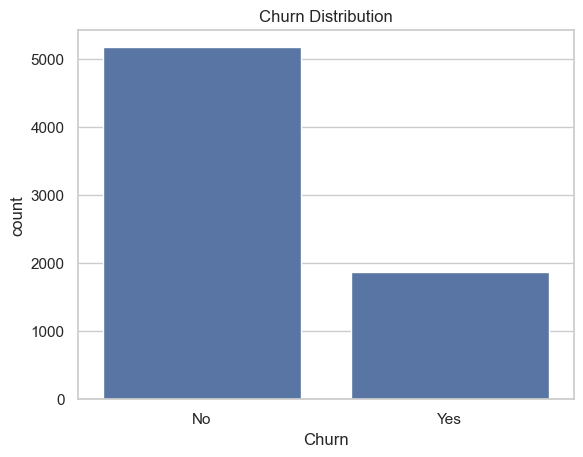

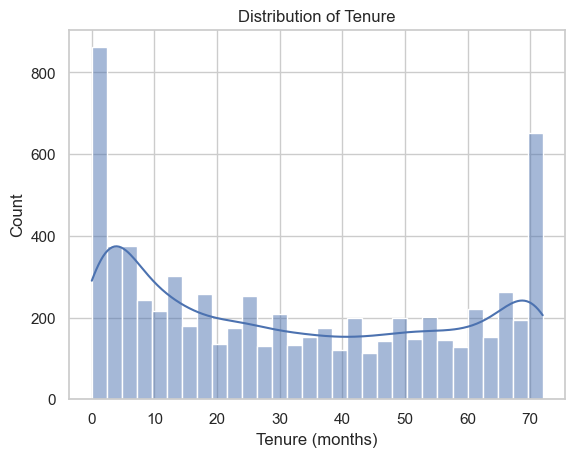

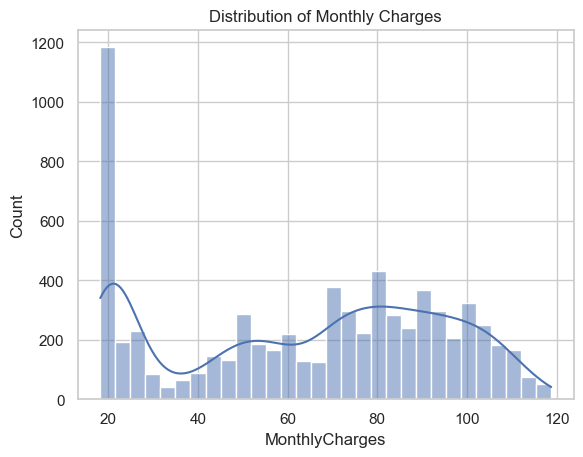

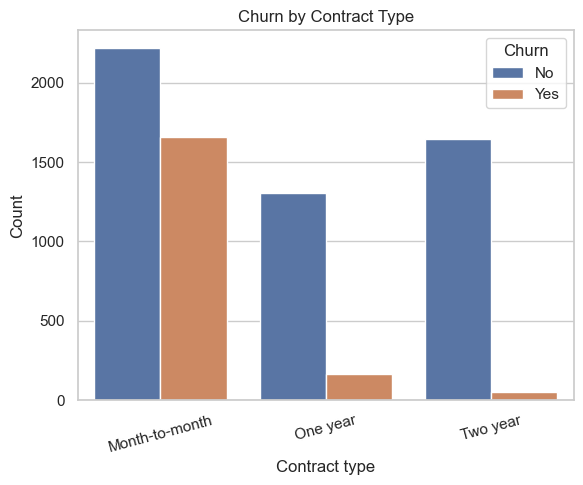

In [157]:
## Phrase 2: Exploratory Data Analysis (EDA)
# Churn distribution (counts and percentage)
print("\nChurn value counts:")
print(df['Churn'].value_counts())
print("\nChurn percentage:")
print(df['Churn'].value_counts(normalize=True) * 100)

plt.figure()
sns.countplot(data=df, x='Churn')
plt.title("Churn Distribution")
plt.show()

# Distribution of tenure (how long customers stay)
plt.figure()
sns.histplot(df['tenure'], bins=30, kde=True)
plt.title("Distribution of Tenure")
plt.xlabel("Tenure (months)")
plt.ylabel("Count")
plt.show()

# Distribution of MonthlyCharges
plt.figure()
sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
plt.title("Distribution of Monthly Charges")
plt.xlabel("MonthlyCharges")
plt.ylabel("Count")
plt.show()

# Relationship: Churn vs Contract 
plt.figure()
sns.countplot(data=df, x='Contract', hue='Churn')
plt.title("Churn by Contract Type")
plt.xlabel("Contract type")
plt.ylabel("Count")
plt.xticks(rotation=15)
plt.show()

In [158]:
## Phrase 3: Data Cleaning
# 1. Handle Total Charges
# In the original dataset, TotalCharges has some blank spaces " "
# which make the whole column type 'object' instead of float.
print("\nTotalCharges type before cleaning:", df['TotalCharges'].dtype)

# Replace spaces with NaN, then convert to numeric (float)
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows where TotalCharges is NaN (only 11 rows)
df = df.dropna(subset=['TotalCharges'])

print("TotalCharges type after cleaning:", df['TotalCharges'].dtype)
print("Number of rows after dropping NaN TotalCharges:", len(df))

# 2. Convert Churn to 0 and 1
# Strip any spaces around the text to ensure no leading or trailing spaces like " Yes" → "Yes"
df['Churn'] = df['Churn'].astype(str).str.strip()

print("\nUnique values in Churn BEFORE mapping:")
print(df['Churn'].unique())

# Map Yes/No to 1/0
# Clean and map Churn correctly
df['Churn'] = df['Churn'].astype(str).str.strip()
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop rows where mapping failed (if got)
df = df.dropna(subset=['Churn'])
df['Churn'] = df['Churn'].astype(int) # ensure Churn is integer type (0 or 1)

print(df['Churn'].value_counts())

print("\nChurn after mapping to 0/1 (including NaN if any):")
print(df['Churn'].value_counts(dropna=False))
print("\nNumber of NaN in Churn:", df['Churn'].isna().sum()) #check for NaN

# 3. Drop CustomerID
# # customerID is a unique identifier and does not carry useful predictive information
df = df.drop(columns=['customerID'], errors='ignore')

print("\nColumns after dropping customerID:")
print(df.columns)
print("\nCurrent shape of dataframe (rows, columns):", df.shape)


TotalCharges type before cleaning: object
TotalCharges type after cleaning: float64
Number of rows after dropping NaN TotalCharges: 7032

Unique values in Churn BEFORE mapping:
['No' 'Yes']
Churn
0    5163
1    1869
Name: count, dtype: int64

Churn after mapping to 0/1 (including NaN if any):
Churn
0    5163
1    1869
Name: count, dtype: int64

Number of NaN in Churn: 0

Columns after dropping customerID:
Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Current shape of dataframe (rows, columns): (7032, 20)


In [159]:
## Phrase 4: Feature and Target Separation & One-Hot Encoding (technique to convert categorical variables into numerical format)
# 1. Separate features and target
# Target variable
y = df['Churn'] # label that we want to predict

# Features 
X = df.drop('Churn', axis=1) # all columns except Churn

print("\nShape of X (features):", X.shape)
print("Shape of y (target):", y.shape)

# 2. Identify categorical and numerical columns 
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(exclude=['object']).columns

print("\nCategorical columns:")
print(list(cat_cols))

print("\nNumerical columns:")
print(list(num_cols))

# 3. Use pandas.get_dummies to one-hot encode categorical features
# converts each category into binary indicator columns
X_encoded = pd.get_dummies(X, drop_first=True) # drop_first=True avoids redundant columns 

print("\nOriginal shape:", X.shape)
print("Encoded shape:", X_encoded.shape)
print("Encoded feature columns:")
print(X_encoded.columns[:10])  # print first 10 to check


Shape of X (features): (7032, 19)
Shape of y (target): (7032,)

Categorical columns:
['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Numerical columns:
['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

Original shape: (7032, 19)
Encoded shape: (7032, 30)
Encoded feature columns:
Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes',
       'MultipleLines_No phone service', 'MultipleLines_Yes'],
      dtype='object')


In [160]:
# Phase 5: Train, Validation, Test Split and Standardisation
# 1. Split into Test 70 / 15 / 15
# 1st split: 70% train, 30% temp (val + test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded,
    y,
    train_size=0.7,    # 70% training data
    random_state=42,   # fixed seed for reproducibility
    stratify=y        # keep churn ratio similar across splits
)

# 2nd split: for the 30%, half for validation, half for test to 15% / 15%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    train_size=0.5,    # 50% of the remaining 30%
    random_state=42,
    stratify=y_temp
)

print("\nTrain shape:", X_train.shape, y_train.shape)
print("Validation shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

# Helper function: print churn ratio in each split
def print_class_ratio(name, y_data):
    print(f"{name} set class distribution (%):")
    print(y_data.value_counts(normalize=True) * 100)
    print()

print_class_ratio("Train", y_train)
print_class_ratio("Validation", y_val)
print_class_ratio("Test", y_test)


# Oversampling with SMOTE on Train set only
print("\nBefore SMOTE oversampling:")
print(y_train.value_counts())

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train) # fit_resample to generate synthetic samples and nearest neighbors

print("\nAfter SMOTE oversampling:")
print(y_train_res.value_counts())


# 2. Standardisation (scale the features)
scaler = StandardScaler()

# Fit only on training data only to avoid data leakage
scaler.fit(X_train_res)

# Transform train, validation, and test with the same scaler
X_train_scaled = scaler.transform(X_train_res)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("\nAfter scaling:")
print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape:", X_val_scaled.shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Input dimension for neural network (number of features after encoding)
input_dimension = X_train_scaled.shape[1]
print("\nInput dimension (number of features):", input_dimension)


Train shape: (4922, 30) (4922,)
Validation shape: (1055, 30) (1055,)
Test shape: (1055, 30) (1055,)
Train set class distribution (%):
Churn
0    73.425437
1    26.574563
Name: proportion, dtype: float64

Validation set class distribution (%):
Churn
0    73.364929
1    26.635071
Name: proportion, dtype: float64

Test set class distribution (%):
Churn
0    73.459716
1    26.540284
Name: proportion, dtype: float64


Before SMOTE oversampling:
Churn
0    3614
1    1308
Name: count, dtype: int64

After SMOTE oversampling:
Churn
1    3614
0    3614
Name: count, dtype: int64

After scaling:
X_train_scaled shape: (7228, 30)
X_val_scaled shape: (1055, 30)
X_test_scaled shape: (1055, 30)

Input dimension (number of features): 30


In [161]:
from sklearn.neural_network import MLPClassifier

# Fucntion to train and evaluate the MLP with early stopping

def train_and_evaluate(X_train_scaled, y_train, X_val_scaled, y_val,
                       hidden_layers=(16,),
                       activation='relu', # relu used for faster convergence (default)
                       alpha=0.005, # L2 regularization term to reduce overfitting
                       learning_rate_init=0.001, # step size in gradient descent [adjusting weight updates] Chagen 
                    #    learning_rate='adaptive',
                       batch_size=64, # number of samples per gradient update
                       max_epochs=200,
                       random_state=42,
                       patience=15):
    """
    Train MLP epoch-by-epoch with manual early stopping.
    Returns model, train_acc_history, val_acc_history.
    """
    # Initialize MLPClassifier model
    mlp = MLPClassifier(
        hidden_layer_sizes=hidden_layers,
        activation=activation,
        solver='adam', # optimizer algorithm for automatic adjustment of weights during training     
        alpha=alpha,        
        learning_rate_init=learning_rate_init,
        batch_size=batch_size,
        random_state=random_state,
        max_iter=1, # train one epoch at a time
        warm_start=True, # keep previous weights when calling fit multiple times instead reinitializing
    )
    
    # Histories list to store accuracy and loss
    train_acc_hist = []
    val_acc_hist = []
    train_loss_hist = [] 
    val_loss_hist   = [] 

    best_val_acc = 0.0 # decimal to track best validation accuracy
    epochs_without_improvement = 0 # how many count of epochs without improvement

    for epoch in range(1, max_epochs + 1):
        # train model
        mlp.fit(X_train_scaled, y_train)


        '''
        # Predict probabilities for train and validation sets
        y_train_pred  = mlp.predict(X_train_scaled) # predicted class labels not used here just put here as if use test data need to predict first
        y_val_pred    = mlp.predict(X_val_scaled) # predicted class labels not used here just put here as if use test data need to predict first
        '''
        y_train_proba = mlp.predict_proba(X_train_scaled)[:, 1] # probability of positive class (churn=1) for log loss calculation
        y_val_proba   = mlp.predict_proba(X_val_scaled)[:, 1] # probability of positive class (churn=1) for log loss calculation
        # predict_proba gives probability estimates for each class, use when want to know how confident the model is about its predictions; used in log-loss, ROC-AUC, etc.

        # Evaluate
        # Calculate training and validation accuracy
        train_acc = mlp.score(X_train_scaled, y_train)
        val_acc   = mlp.score(X_val_scaled, y_val)
        train_acc_hist.append(train_acc)
        val_acc_hist.append(val_acc)

        # Calculate log loss for training and validation sets
        train_loss = log_loss(y_train, y_train_proba)
        val_loss   = log_loss(y_val,   y_val_proba)
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        
        # Print epoch results
        print(f"Epoch {epoch:03d}: "
              f"Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, "
              f"Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

        # Check for improvement (early stopping)
        if val_acc > best_val_acc + 1e-4:  # small threshold to avoid tiny improvements
            best_val_acc = val_acc
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

            # Early stopping condition
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch}")
                break

    print(f"\nBest validation accuracy: {best_val_acc:.4f}")
    print("\n--------------------------------------")
    print(f"Architecture: {hidden_layers}")
    print(f"Activation : {activation}")
    print(f"Train Acc  : {train_acc:.4f}")
    print(f"Val Acc    : {val_acc:.4f}")

    return mlp, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist

# Train and Evaluate the Neural Network
final_model, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_and_evaluate(
    X_train_scaled, y_train_res,
    X_val_scaled, y_val,
    hidden_layers=(16,), 
    max_epochs=200,
    patience=15
)


c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_pe

Epoch 001: Train Acc=0.7071, Val Acc=0.6398, Train Loss=0.5618, Val Loss=0.6514
Epoch 002: Train Acc=0.7809, Val Acc=0.7346, Train Loss=0.4589, Val Loss=0.5141
Epoch 003: Train Acc=0.7990, Val Acc=0.7441, Train Loss=0.4226, Val Loss=0.4945
Epoch 004: Train Acc=0.8066, Val Acc=0.7602, Train Loss=0.4039, Val Loss=0.4844
Epoch 005: Train Acc=0.8150, Val Acc=0.7630, Train Loss=0.3927, Val Loss=0.4788
Epoch 006: Train Acc=0.8181, Val Acc=0.7716, Train Loss=0.3850, Val Loss=0.4750
Epoch 007: Train Acc=0.8214, Val Acc=0.7773, Train Loss=0.3789, Val Loss=0.4719
Epoch 008: Train Acc=0.8262, Val Acc=0.7829, Train Loss=0.3739, Val Loss=0.4694
Epoch 009: Train Acc=0.8278, Val Acc=0.7839, Train Loss=0.3696, Val Loss=0.4671
Epoch 010: Train Acc=0.8284, Val Acc=0.7886, Train Loss=0.3660, Val Loss=0.4655


c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_pe

Epoch 011: Train Acc=0.8302, Val Acc=0.7810, Train Loss=0.3627, Val Loss=0.4643
Epoch 012: Train Acc=0.8320, Val Acc=0.7829, Train Loss=0.3597, Val Loss=0.4633
Epoch 013: Train Acc=0.8334, Val Acc=0.7829, Train Loss=0.3571, Val Loss=0.4622
Epoch 014: Train Acc=0.8341, Val Acc=0.7858, Train Loss=0.3547, Val Loss=0.4610
Epoch 015: Train Acc=0.8355, Val Acc=0.7877, Train Loss=0.3525, Val Loss=0.4596
Epoch 016: Train Acc=0.8377, Val Acc=0.7848, Train Loss=0.3505, Val Loss=0.4582
Epoch 017: Train Acc=0.8385, Val Acc=0.7848, Train Loss=0.3485, Val Loss=0.4569
Epoch 018: Train Acc=0.8401, Val Acc=0.7848, Train Loss=0.3468, Val Loss=0.4560
Epoch 019: Train Acc=0.8412, Val Acc=0.7848, Train Loss=0.3453, Val Loss=0.4553
Epoch 020: Train Acc=0.8417, Val Acc=0.7858, Train Loss=0.3436, Val Loss=0.4543
Epoch 021: Train Acc=0.8434, Val Acc=0.7858, Train Loss=0.3421, Val Loss=0.4538
Epoch 022: Train Acc=0.8439, Val Acc=0.7867, Train Loss=0.3405, Val Loss=0.4529
Epoch 023: Train Acc=0.8444, Val Acc=0.7

c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\sumho\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_pe

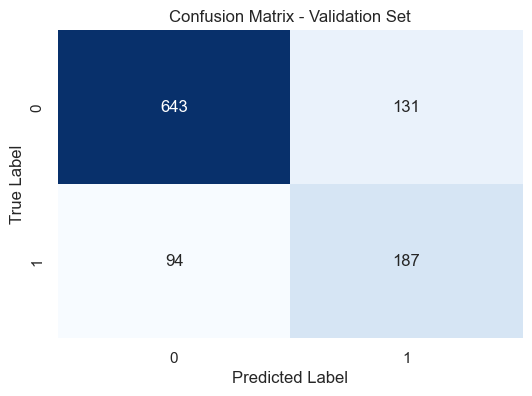


Classification Report - Validation Set:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       774
           1       0.59      0.67      0.62       281

    accuracy                           0.79      1055
   macro avg       0.73      0.75      0.74      1055
weighted avg       0.80      0.79      0.79      1055



' --- IGNORE ---\nAnalyse Confusion Matrix and Classification Report (Hon You)\nA) Confusion Matrix\n- Total of 1055 samples in validation set which is correct \n- there is 647 + 184 true and false positive predictions (correctly predicted churned customers)\n- there is 127 + 97 true an d false negative predictions (correctly predicted non-churned customers)\n- The model seems to perform reasonably well in identifying churned customers, but there are still a significant number of false negatives (97), indicating that some churned customers are being misclassified as non-churned.\n\nB) Classification Report\n- Precision for class 1 (churned) is 0.59, indicating that when the model predicts a customer will churn, it is correct 59% of the time.\n- 0.59 is not good, meaning that there are quite a few false positives (customers predicted to churn but actually did not).\n- Recall for class 1 is 0.65, indicating that the model correctly identifies 65% of all actual churned customers.\n- 0.65 

In [162]:
# Confusion Matrix and Classification Report on Validation Set
# Generate predictions on validation set
y_val_pred = final_model.predict(X_val_scaled)
cm = confusion_matrix(y_val, y_val_pred) # true positives, true negatives, false positives, and false negatives.

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print("\nClassification Report - Validation Set:")
print(classification_report(y_val, y_val_pred))
# Precision is the ratio of correctly predicted positive observations to the total predicted positives. It indicates the accuracy of positive predictions.
# Recall (Sensitivity) is the ratio of correctly predicted positive observations to all actual positives. It indicates how well the model can find all the positive samples.
# F1-score is the weighted average of Precision and Recall. It will tell you overall how good for the model is for each class. 


''' --- IGNORE ---
Analyse Confusion Matrix and Classification Report (Hon You)
A) Confusion Matrix
- Total of 1055 samples in validation set which is correct 
- there is 647 + 184 true and false positive predictions (correctly predicted churned customers)
- there is 127 + 97 true an d false negative predictions (correctly predicted non-churned customers)
- The model seems to perform reasonably well in identifying churned customers, but there are still a significant number of false negatives (97), indicating that some churned customers are being misclassified as non-churned.

B) Classification Report
- Precision for class 1 (churned) is 0.59, indicating that when the model predicts a customer will churn, it is correct 59% of the time.
- 0.59 is not good, meaning that there are quite a few false positives (customers predicted to churn but actually did not).
- Recall for class 1 is 0.65, indicating that the model correctly identifies 65% of all actual churned customers.
- 0.65 is not good, meaning that there are quite a few false negatives (customers who churned but were predicted as non-churned).
- F1-score for class 1 is 0.62, which is not very high, indicating a balance between precision and recall but still room for improvement.
- Overall accuracy of the model on the validation set is 0.74, meaning that 74% of all predictions (both churned and non-churned) are correct.
'''

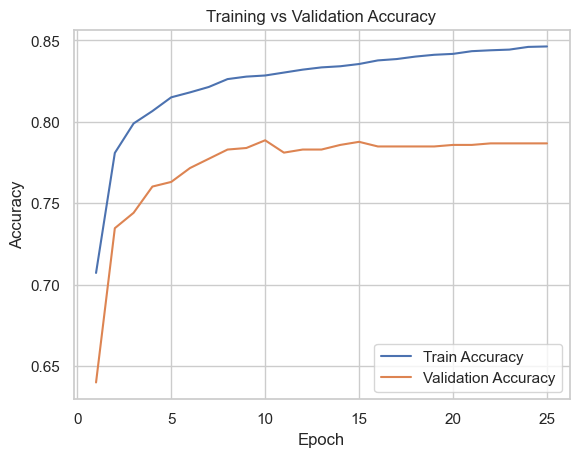

' \nAnalyse from the graph (hon you)\n- The model shows good performance on the validation set, indicating effective learning without overfitting.\n- Both training and validation accuracy curves rise steadily, suggesting that the model is learning the underlying patterns in the data.\n- The gap between training and validation accuracy is minimal, indicating that the model generalizes well to unseen data.\n- The training accuracy is higher than validation accuracy, which is expected, but the difference is not too large, suggesting that overfitting is controlled.\n- Overall, the accuracy curves suggest that the model is well-tuned and capable of making reliable predictions on new data.\n'

In [163]:
# Plot training and validation accuracy curves
epochs = range(1, len(train_acc_hist) + 1)

plt.figure()
plt.plot(epochs, train_acc_hist, label='Train Accuracy')
plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

''' 
Analyse from the graph (hon you)
- The model shows good performance on the validation set, indicating effective learning without overfitting.
- Both training and validation accuracy curves rise steadily, suggesting that the model is learning the underlying patterns in the data.
- The gap between training and validation accuracy is minimal, indicating that the model generalizes well to unseen data.
- The training accuracy is higher than validation accuracy, which is expected, but the difference is not too large, suggesting that overfitting is controlled.
- Overall, the accuracy curves suggest that the model is well-tuned and capable of making reliable predictions on new data.
'''


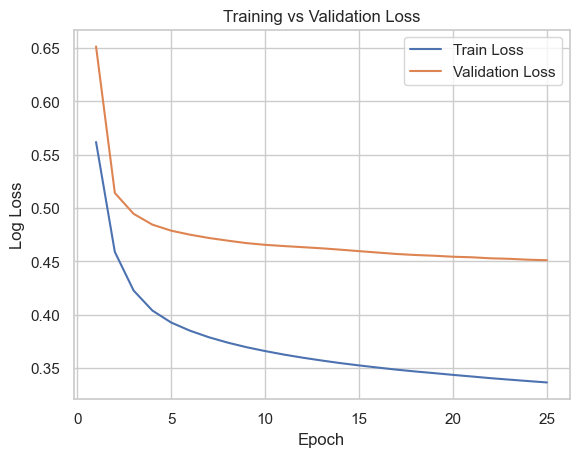

"\nAnalyse from the graph (hon you)\n- The training and validation loss curves indicate that the model is learning effectively over epochs.\n- Both curves show a downward trend, suggesting that the model is minimizing the loss function and improving its predictions.\n- The training loss is consistently lower than the validation loss, which is expected as the model optimizes on the training data.\n- Both curves didn't show sign of increasing again, indicating no overfitting observed.\n- Overall, the loss curves suggest that the model is well-optimized and capable of making accurate predictions.\n"

In [164]:
# Plot training and validation loss curves
epochs = range(1, len(train_loss_hist) + 1)

plt.figure()
plt.plot(epochs, train_loss_hist, label='Train Loss')
plt.plot(epochs, val_loss_hist,   label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Log Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

'''
Analyse from the graph (hon you)
- The training and validation loss curves indicate that the model is learning effectively over epochs.
- Both curves show a downward trend, suggesting that the model is minimizing the loss function and improving its predictions.
- The training loss is consistently lower than the validation loss, which is expected as the model optimizes on the training data.
- Both curves didn't show sign of increasing again, indicating no overfitting observed.
- Overall, the loss curves suggest that the model is well-optimized and capable of making accurate predictions.
'''

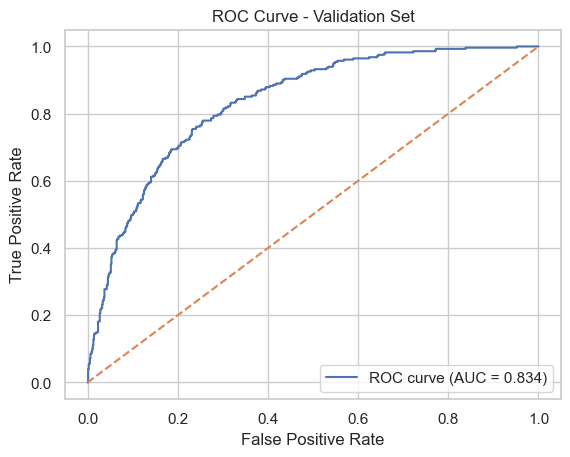

Validation ROC-AUC: 0.8336


"\nAnalysis of ROC Curve and AUC from the graph (hon you)\n- The ROC curve demonstrates the model's ability to distinguish between churn and non-churn customers.\n- The curve bows significantly above the diagonal line, indicating strong classification performance.\n- The curve's shape suggests that the model effectively balances sensitivity and specificity across different thresholds.\n- The curve is above the random guessing line which is expected\n- The value of AUC (Area Under the Curve) is 0.8475 / 1, indicating good overall performance.\n"

In [165]:
# Validation ROC (ROC-AUC curve)
y_val_proba = final_model.predict_proba(X_val_scaled)[:, 1] # pick the probability of positive class (churn=1) for each sample, used in roc_curve and roc_auc_score

# fpr: false positive rate, tpr: true positive rate, thresholds: decision thresholds
fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)

# AUC near 0.5 means random guessing, 1.0 means perfect classifier
roc_auc = roc_auc_score(y_val, y_val_proba)

# The ROC curve should be above the diagonal line (random guessing dotted line)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle='--')  # random baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend(loc="lower right")
plt.show()

print(f"Validation ROC-AUC: {roc_auc:.4f}")


'''
Analysis of ROC Curve and AUC from the graph (hon you)
- The ROC curve demonstrates the model's ability to distinguish between churn and non-churn customers.
- The curve bows significantly above the diagonal line, indicating strong classification performance.
- The curve's shape suggests that the model effectively balances sensitivity and specificity across different thresholds.
- The curve is above the random guessing line which is expected
- The value of AUC (Area Under the Curve) is 0.8475 / 1, indicating good overall performance.
'''



=== TEST EVALUATION ===


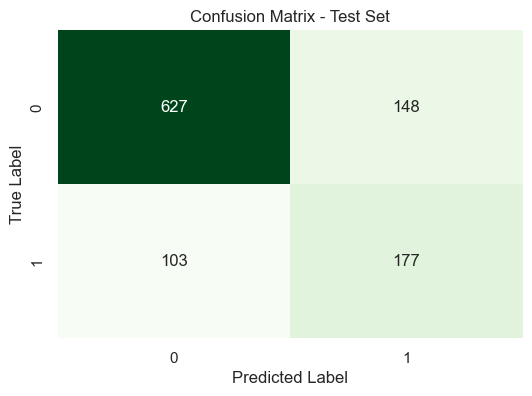


Classification Report - Test Set:
              precision    recall  f1-score   support

           0     0.8589    0.8090    0.8332       775
           1     0.5446    0.6321    0.5851       280

    accuracy                         0.7621      1055
   macro avg     0.7018    0.7206    0.7092      1055
weighted avg     0.7755    0.7621    0.7674      1055

Test Accuracy  : 0.7621
Test ROC-AUC   : 0.8119


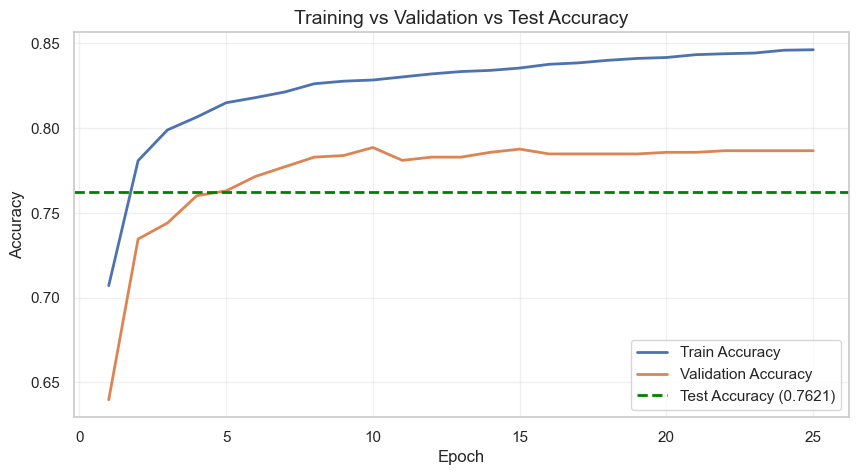

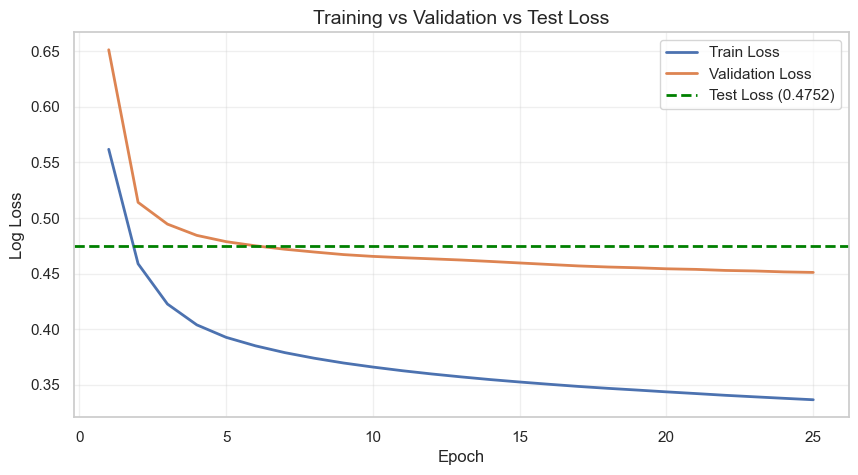

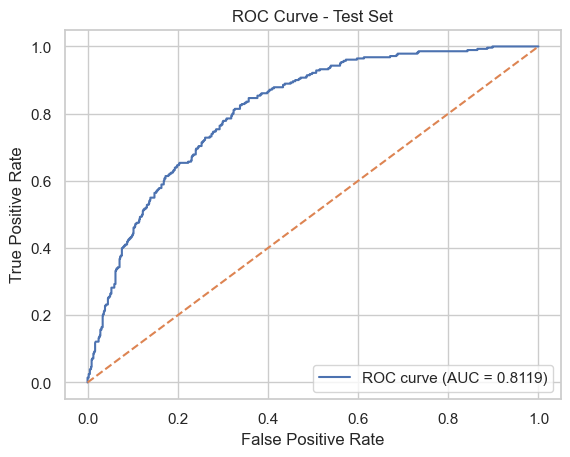


Test results summary:
  test_accuracy: 0.7621
  roc_auc: 0.8119
  test_loss: 0.4752
  confusion_matrix: min=103.0000, max=627.0000, mean=263.7500
  classification_report: dict with keys ['0', '1', 'accuracy']...
  train_acc_history: min=0.7071, max=0.8463, mean=0.8248
  val_acc_history: min=0.6398, max=0.7886, mean=0.7730
  train_loss_history: min=0.3365, max=0.5618, mean=0.3732
  val_loss_history: min=0.4511, max=0.6514, mean=0.4730


In [166]:
# TEST EVALUATION
print("\n=== TEST EVALUATION ===")

# Predictions and probabilities on test set
y_test_pred = final_model.predict(X_test_scaled)
y_test_proba = final_model.predict_proba(X_test_scaled)[:, 1]
test_acc = final_model.score(X_test_scaled, y_test)
test_loss = log_loss(y_test, y_test_proba)

# Confusion matrix (plot)
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report (precision, recall, f1)
print("\nClassification Report - Test Set:")
print(classification_report(y_test, y_test_pred, digits=4))

# Accuracy and basic metrics (clear numeric output)
test_accuracy = (y_test_pred == y_test).mean()
roc_auc_test = roc_auc_score(y_test, y_test_proba)
print(f"Test Accuracy  : {test_accuracy:.4f}")
print(f"Test ROC-AUC   : {roc_auc_test:.4f}")

# Accuracy Curves (TRAIN vs VALIDATION vs TEST)
epochs = range(1, len(train_acc_hist) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc_hist, label='Train Accuracy', linewidth=2)
plt.plot(epochs, val_acc_hist, label='Validation Accuracy', linewidth=2)
plt.axhline(y=test_acc, color='green', linestyle='--', linewidth=2, label=f'Test Accuracy ({test_acc:.4f})')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Training vs Validation vs Test Accuracy", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# Loss Curves (TRAIN vs VALIDATION vs TEST)
epochs = range(1, len(train_loss_hist) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss_hist, label='Train Loss', linewidth=2)
plt.plot(epochs, val_loss_hist, label='Validation Loss', linewidth=2)
plt.axhline(y=test_loss, color='green', linestyle='--', linewidth=2, label=f'Test Loss ({test_loss:.4f})')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Log Loss", fontsize=12)
plt.title("Training vs Validation vs Test Loss", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# ROC curve (plot)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
plt.figure()
plt.plot(fpr_test, tpr_test, label=f"ROC curve (AUC = {roc_auc_test:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Set")
plt.legend(loc="lower right")
plt.show()

# Save numeric results to a small dict for later reporting
test_results = {
    "test_accuracy": test_accuracy,
    "roc_auc": roc_auc_test,
    "test_loss": test_loss,
    "confusion_matrix": cm_test,
    "classification_report": classification_report(y_test, y_test_pred, output_dict=True),
    "train_acc_history": train_acc_hist,
    "val_acc_history": val_acc_hist,
    "train_loss_history": train_loss_hist,
    "val_loss_history": val_loss_hist
}
# Print short summary
print("\nTest results summary:")
for k, v in test_results.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    elif isinstance(v, (list, np.ndarray)):
        # Show min, max, and mean of the history instead of length
        arr = np.array(v)
        print(f"  {k}: min={arr.min():.4f}, max={arr.max():.4f}, mean={arr.mean():.4f}")
    elif isinstance(v, dict):
        print(f"  {k}: dict with keys {list(v.keys())[:3]}...")
    else:
        print(f"  {k}: {type(v).__name__}")

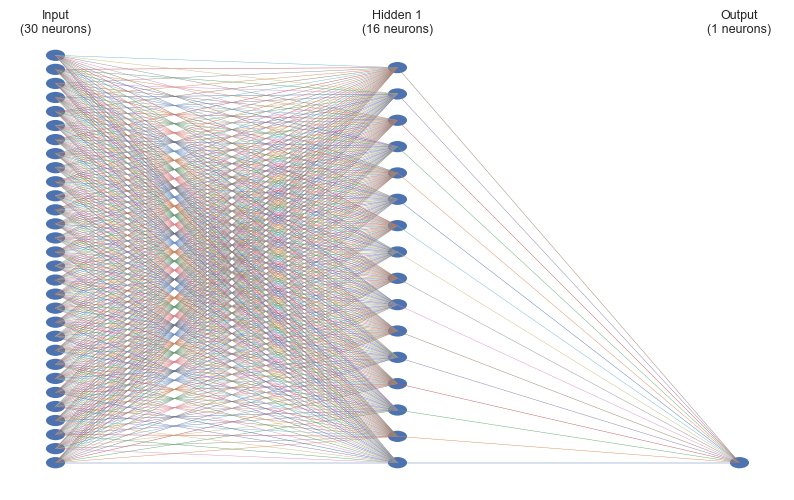

'\nHon You\n- 1 neuron in output layer is correct for binary classification task (churn vs non-churn)\n- This sigmoid activation function is appropriate for binary classification as it outputs values between 0 and 1, representing probabilities for class 1 (churn).\n'

In [167]:
# Visualise the MLP structure
def plot_mlp_structure(mlp):
    """
    Simple visualisation of MLP architecture using circles and lines.
    """
    # layer sizes from weights
    layer_sizes = [mlp.coefs_[0].shape[0]]  # input layer
    layer_sizes += [w.shape[1] for w in mlp.coefs_]  # hidden + output

    n_layers = len(layer_sizes)
    v_spacing = 1.0 / max(layer_sizes)
    h_spacing = 1.0 / (n_layers - 1)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')

    # store neuron positions to draw connections
    positions = []

    for i, layer_size in enumerate(layer_sizes):
        x = i * h_spacing
        ys = np.linspace(0, 1, layer_size, endpoint=False) + v_spacing / 2
        positions.append([(x, y) for y in ys])

        # draw neurons
        for y in ys:
            circle = plt.Circle((x, y), 0.015, fill=True)
            ax.add_patch(circle)

    # draw connections
    for i in range(n_layers - 1):
        for (x0, y0) in positions[i]:
            for (x1, y1) in positions[i + 1]:
                ax.plot([x0, x1], [y0, y1], linewidth=0.3)

    titles = ["Input"] + \
             [f"Hidden {i}" for i in range(1, n_layers - 1)] + \
             ["Output"]

    for i, (layer_size, title) in enumerate(zip(layer_sizes, titles)):
        x = i * h_spacing
        ax.text(x, 1.03, f"{title}\n({layer_size} neurons)",
                ha='center', va='bottom', fontsize=9)


    plt.show()

# call after training
plot_mlp_structure(final_model)

'''
Hon You
- 1 neuron in output layer is correct for binary classification task (churn vs non-churn)
- This sigmoid activation function is appropriate for binary classification as it outputs values between 0 and 1, representing probabilities for class 1 (churn).
'''


In [168]:
# Test Set

In [169]:
# For here i just commented, because this one is test for different model architecture comparison
# results = {}

# # Model 1 — Small network
# results['model_16'] = train_and_evaluate(hidden_layers=(16,8))

# # Model 2 — Medium network
# results['model_32_16'] = train_and_evaluate(hidden_layers=(32,16))

# # Model 3 — Large network
# results['model_64_32'] = train_and_evaluate(hidden_layers=(64,32))

# # Optional: deeper network
# results['model_32_16_8'] = train_and_evaluate(hidden_layers=(32,16,8))


In [170]:
'''
# Import joblib for saving the model
import joblib 

# 1. Test Set Predictions
print("--- Evaluating Final Model on Test Set ---")

# Generate predictions and probability scores on the held-out test set
y_test_pred = final_model.predict(X_test_scaled)
# Extract the probability for the positive class (Churn=1)
y_test_proba = final_model.predict_proba(X_test_scaled)[:, 1]

# 2. Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate and display the Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Print the Classification Report
print("\nClassification Report - Test Set:")
print(classification_report(y_test, y_test_pred))


# 3. ROC Curve and AUC Score
# Calculate ROC curve and AUC
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_proba)
roc_auc_test = roc_auc_score(y_test, y_test_proba)

# Plot the ROC Curve
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2,
         label=f"ROC curve (Area = {roc_auc_test:.4f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity)")
plt.title("Receiver Operating Characteristic (ROC) - Test Set")
plt.legend(loc="lower right")
plt.show()

print(f"\nFinal Test Set ROC-AUC Score: {roc_auc_test:.4f}")

# 4. Save the Final Model
filename = 'final_telco_churn_nn_model.joblib'
joblib.dump(final_model, filename)
print(f"\nfinal model successfully saved as: {filename}")

'''

'\n# Import joblib for saving the model\nimport joblib \n\n# 1. Test Set Predictions\nprint("--- Evaluating Final Model on Test Set ---")\n\n# Generate predictions and probability scores on the held-out test set\ny_test_pred = final_model.predict(X_test_scaled)\n# Extract the probability for the positive class (Churn=1)\ny_test_proba = final_model.predict_proba(X_test_scaled)[:, 1]\n\n# 2. Confusion Matrix and Classification Report\nfrom sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Calculate and display the Confusion Matrix\ncm_test = confusion_matrix(y_test, y_test_pred)\n\nplt.figure(figsize=(6, 4))\nsns.heatmap(cm_test, annot=True, fmt=\'d\', cmap=\'Blues\', cbar=False,\n            xticklabels=[\'No Churn\', \'Churn\'], yticklabels=[\'No Churn\', \'Churn\'])\nplt.title("Confusion Matrix - Test Set")\nplt.xlabel("Predicted Label")\nplt.ylabel("True Label")\nplt.show()\n\n# Print 